Loading Household Member Data (Analyzing Child Anemia)...


/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_4243/1546435210.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['w'] = df['hv005'] / 1000000.0


Analyzing 3699 tested children (Rwanda) and 915 (East).

--- Final Results (Target: East 33%, Rwanda 37%) ---
           Anemia %
Location           
Rwamagana        28
Nyagatare        29
Gatsibo          33
Kayonza          45
Kirehe           38
Ngoma            34
Bugesera         29
East             33
Rwanda           37
✅ Success! JSON: eastern_child_anemia_prevalence.json, Plot: Child_Anemia_Prevalence.png


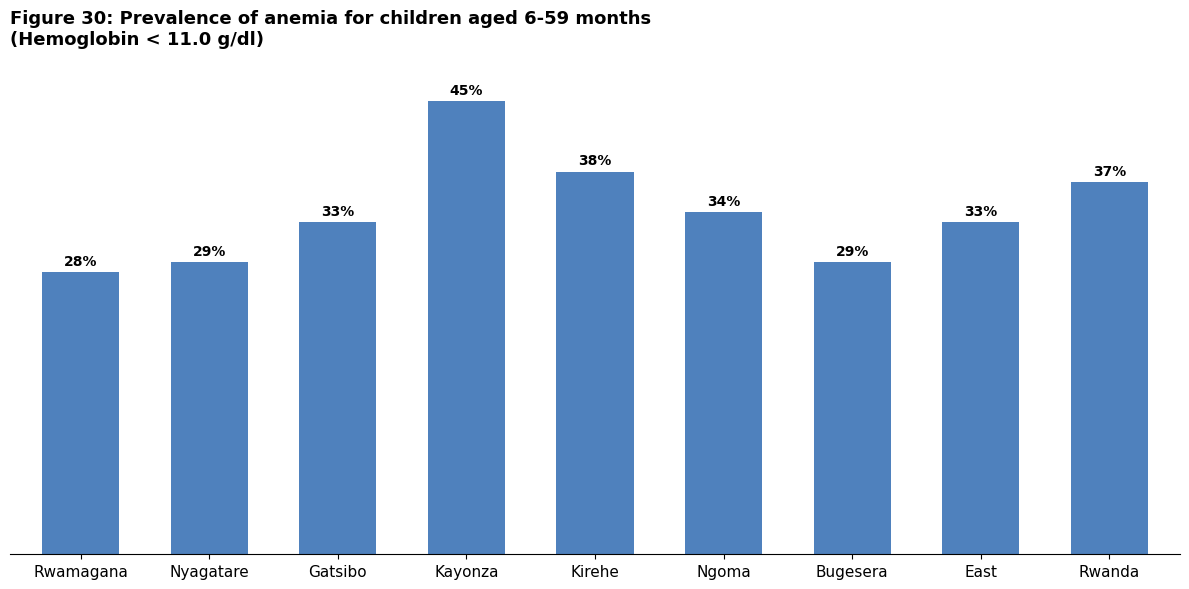

In [1]:
#!/usr/bin/env python3
# dhs_anemia_children_final.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
# PR file is the standard for biomarker data like anemia
FILE_PATH = os.path.join(DATA_DIR, "RWPR81FL.DTA")

DIST_MAP = {
    51: 'Rwamagana', 52: 'Nyagatare', 53: 'Gatsibo',
    54: 'Kayonza', 55: 'Kirehe', 56: 'Ngoma', 57: 'Bugesera'
}

# ------------------------------------------------------------------
# 2. CALCULATION HELPERS
# ------------------------------------------------------------------
def standard_round(n):
    """RDHS Report rounding (0.5 becomes 1)."""
    return int(math.floor(n + 0.5))

def get_anemia_stats(df):
    """Calculates weighted percentage of anemia (hc57 in 1,2,3)."""
    if df.empty or 'w' not in df.columns or df['w'].sum() == 0:
        return 0
    
    # hc57 Anemia level: 1=Severe, 2=Moderate, 3=Mild, 4=Not anemic
    # Anemic = level 1, 2, or 3
    is_anemic = df['hc57'].isin([1, 2, 3])
    raw_pct = np.average(is_anemic, weights=df['w']) * 100
    return standard_round(raw_pct)

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found. Ensure RWPR81FL.DTA is in the data folder."); exit()

    print("Loading Household Member Data (Analyzing Child Anemia)...")
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # --- FORCED NUMERIC CONVERSION ---
    # hc1: Age in months | hc57: Anemia level | hv005a: Anemia Weight
    cols_to_fix = ['hv005a', 'hv005', 'hv024', 'shdistrict', 'hc1', 'hc57']
    for col in cols_to_fix:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # --- WEIGHTING ---
    # DHS uses hv005a for biomarker data (Anemia weight)
    # Fallback to hv005 if hv005a is not present/populated
    if 'hv005a' in df.columns and df['hv005a'].sum() > 0:
        df['w'] = df['hv005a'] / 1000000.0
    else:
        df['w'] = df['hv005'] / 1000000.0

    # --- FILTERS ---
    # 1. Children aged 6-59 months
    df_child = df[(df['hc1'] >= 6) & (df['hc1'] <= 59)].copy()

    # 2. Must have a valid anemia test result (Exclude 'Not tested' / 9)
    df_child = df_child[df_child['hc57'].isin([1, 2, 3, 4])].copy()

    if df_child.empty:
        print("❌ Error: No valid anemia data found for children 6-59 months."); exit()

    # --- AGGREGATION ---
    results = {}
    dist_col = 'shdistrict' if 'shdistrict' in df_child.columns else 'hv001'
    
    # Filter Eastern Province (Region 5)
    df_east = df_child[df_child['hv024'] == 5].copy()
    
    print(f"Analyzing {len(df_child)} tested children (Rwanda) and {len(df_east)} (East).")

    for code, name in DIST_MAP.items():
        subset = df_east[df_east[dist_col] == code]
        results[name] = get_anemia_stats(subset)

    # Totals
    results["East"] = get_anemia_stats(df_east)
    results["Rwanda"] = get_anemia_stats(df_child)

    # Create Final DataFrame
    final_df = pd.DataFrame(list(results.items()), columns=["Location", "Anemia %"]).set_index("Location")
    
    print("\n--- Final Results (Target: East 33%, Rwanda 37%) ---")
    print(final_df)

    # --- OUTPUTS ---
    json_name = "eastern_child_anemia_prevalence.json"
    with open(json_name, "w") as f:
        json.dump(final_df["Anemia %"].to_dict(), f, indent=4)

    # Plot (Matches Section 6.4 visual requirements)
    colors = ["#4F81BD"] * 7 + ["#00B050", "#ED7D31"]
    ax = final_df.plot(kind="bar", color=colors, figsize=(12, 6), width=0.6, legend=False)
    
    plt.title("Figure 30: Prevalence of anemia for children aged 6-59 months\n(Hemoglobin < 11.0 g/dl)", 
              fontsize=13, fontweight="bold", loc='left', pad=25)
    
    plt.xticks(rotation=0, fontsize=11)
    plt.xlabel("")
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: ax.spines[s].set_visible(False)
    
    # Add labels on top of bars
    for c in ax.containers:
        ax.bar_label(c, fmt='%d%%', padding=3, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig("Child_Anemia_Prevalence.png", dpi=300)
    print(f"✅ Success! JSON: {json_name}, Plot: Child_Anemia_Prevalence.png")